In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from arviz.labels import MapLabeller
from IPython.display import Image
from pymc_marketing import clv

In [ ]:
import requests
import zipfile
import os

# Download the zip file
url = "https://archive.ics.uci.edu/static/public/352/online+retail.zip"
response = requests.get(url)
filename = "online_retail.zip"

with open(filename, 'wb') as file:
    file.write(response.content)

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("online_retail_data")

# Finding the Excel file name
for file in os.listdir("online_retail_data"):
    if file.endswith(".xlsx"):
        excel_file = os.path.join("online_retail_data", file)
        break

# Convert from Excel to CSV
data_raw = pd.read_excel(excel_file)

data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Handling Return Orders
# Extracting rows where InvoiceNo starts with "C"
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")]

# Create a temporary DataFrame with the columns we want to match on, and also negate the 'Quantity' column
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the original DataFrame with the temporary DataFrame on the columns we want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']],
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'],
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the original return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])

# Selecting relevant features and calculating total sales
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


In [ ]:
data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm.head()

/usr/local/lib/python3.10/dist-packages/pymc_marketing/clv/utils.py:273: UserWarning: clv_summary was renamed to rfm_summary
  warnings.warn("clv_summary was renamed to rfm_summary", UserWarning, stacklevel=1)


,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12347,12347,6.0,365.0,367.0,599.701667
12348,12348,3.0,283.0,358.0,301.480000
12349,12349,0.0,0.0,18.0,0.000000
12350,12350,0.0,0.0,310.0,0.000000
12352,12352,5.0,260.0,296.0,221.756000


In [ ]:
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()

bgm.fit()
bgm.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.053661e+06,5.307796e+06,3.747192e+06,1.436013e+07,3.738135e+06,3.162293e+06,3.0,35.0,1.89
b,4.986290e+10,1.036117e+09,4.882705e+10,5.089876e+10,7.297092e+08,6.173008e+08,3.0,11.0,2.30
alpha,7.020800e+01,9.430000e-01,6.926500e+01,7.115000e+01,6.640000e-01,5.620000e-01,2.0,13.0,2.49
r,8.280000e-01,2.000000e-03,8.250000e-01,8.300000e-01,2.000000e-03,1.000000e-03,2.0,12.0,2.62


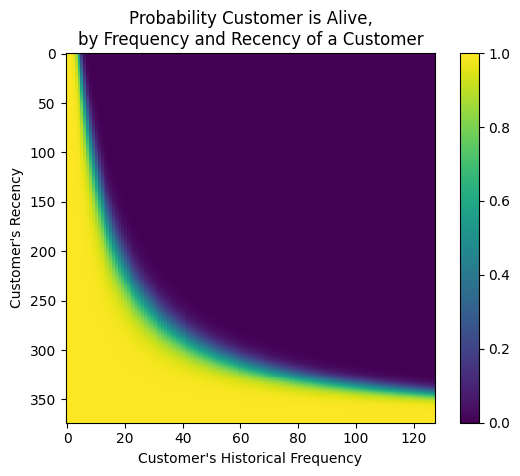

In [ ]:
clv.plot_probability_alive_matrix(bgm)

In [ ]:
num_purchases = bgm.expected_num_purchases(
    customer_id=data_summary_rfm["customer_id"],
    t=365,
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"]
)

sdata = data_summary_rfm.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
customer_id,,,,,,
15311,15311,89.0,373.0,373.0,660.002809,73.469266
17841,17841,111.0,372.0,373.0,341.128018,91.310199
12748,12748,112.0,373.0,373.0,284.600893,92.124697
14911,14911,127.0,372.0,373.0,953.531890,104.251023


In [ ]:
nonzero_data = data_summary_rfm.query("frequency>0")
dataset = pd.DataFrame({
    'customer_id': nonzero_data.customer_id,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})
gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg.fit();

expected_spend = gg.expected_customer_spend(
    customer_id=data_summary_rfm["customer_id"],
    mean_transaction_value=data_summary_rfm["monetary_value"],
    frequency=data_summary_rfm["frequency"],
)

Text(0.5, 0, 'Expected average order value')

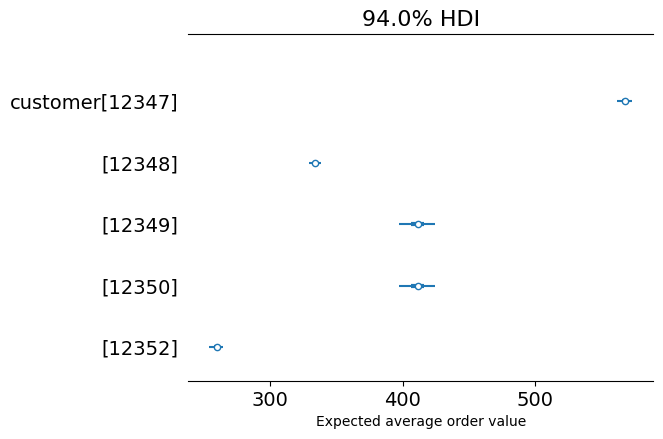

In [ ]:
labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(5))), combined=True, labeller=labeller)
plt.xlabel("Expected average order value")

In [ ]:
clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=data_summary_rfm['customer_id'],
    mean_transaction_value=data_summary_rfm["monetary_value"],
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"],
    time=120, # 120 months = 10 years
    discount_rate=0.01,
    freq="D",
)

clv_df = az.summary(clv_estimate, kind="stats").reset_index()

clv_df['customer_id'] = clv_df['index'].str.extract('(\d+)')[0]

clv_df = clv_df[['customer_id', 'mean', 'hdi_3%', 'hdi_97%']]
clv_df.rename(columns={'mean' : 'clv_estimate', 'hdi_3%': 'clv_estimate_hdi_3%', 'hdi_97%': 'clv_estimate_hdi_97%'}, inplace=True)

# monetary_values = data_summary_rfm.loc[clv_df['customer_id'], 'monetary_value']
monetary_values = data_summary_rfm.set_index('customer_id').loc[clv_df['customer_id'], 'monetary_value']
clv_df['monetary_value'] = monetary_values.values
clv_df.to_csv('clv_estimates_output.csv', index=False)

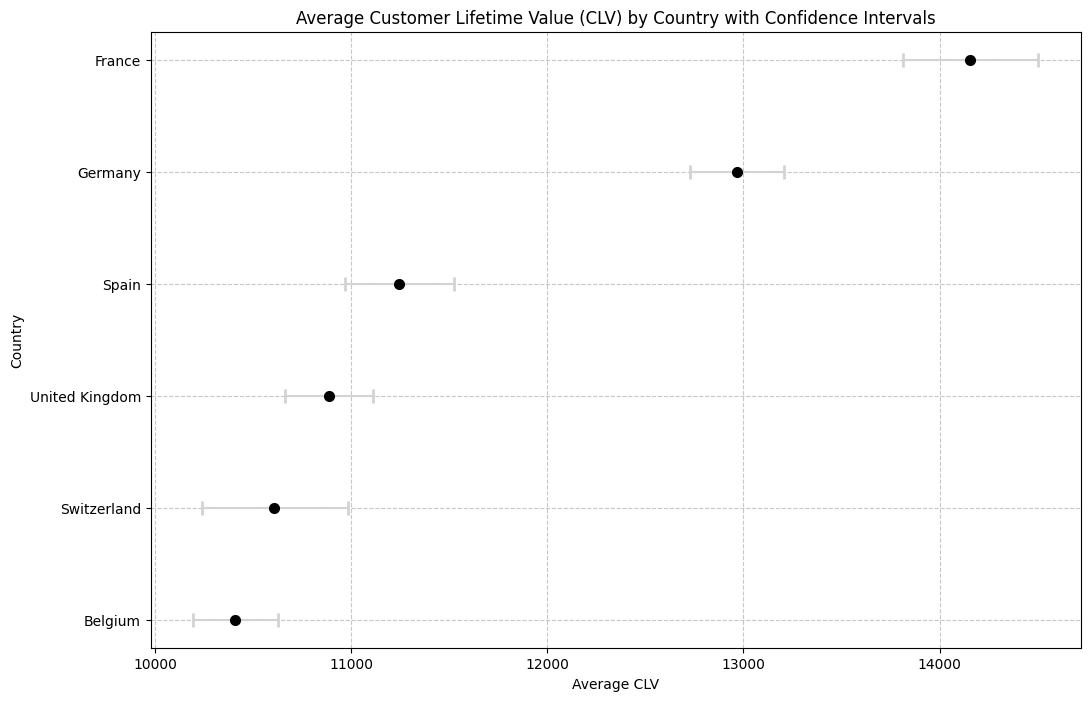

In [ ]:
# Calculating total sales per transaction
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
customer_sales = data.groupby('CustomerID').agg({
    'TotalSales': sum,
    'Country': 'first'  # Assuming a customer is associated with only one country
})


customer_countries = customer_sales.reset_index()[['CustomerID', 'Country']]

clv_with_country = pd.merge(clv_df, customer_countries, left_on='customer_id', right_on='CustomerID', how='left')

average_clv_by_country = clv_with_country.groupby('Country')['clv_estimate'].mean()

customer_count_by_country = data.groupby('Country')['CustomerID'].nunique()

country_clv_summary = pd.DataFrame({
    'AverageCLV': average_clv_by_country,
    'CustomerCount': customer_count_by_country,
})
# Calculate the average lower and upper bounds of the CLV estimates by country
average_clv_lower_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_3%'].mean()
average_clv_upper_by_country = clv_with_country.groupby('Country')['clv_estimate_hdi_97%'].mean()

# Add these averages to the country_clv_summary dataframe
country_clv_summary['AverageCLVLower'] = average_clv_lower_by_country
country_clv_summary['AverageCLVUpper'] = average_clv_upper_by_country

# Filtering countries with more than 20 customers
filtered_countries = country_clv_summary[country_clv_summary['CustomerCount'] >= 20]

# Sorting in descending order by CustomerCount
sorted_countries = filtered_countries.sort_values(by='AverageCLV', ascending=False)

# Prepare the data for error bars
lower_error = sorted_countries['AverageCLV'] - sorted_countries['AverageCLVLower']
upper_error = sorted_countries['AverageCLVUpper'] - sorted_countries['AverageCLV']
asymmetric_error = [lower_error, upper_error]

# Create a new figure with a specified size
plt.figure(figsize=(12,8))

# Create a plot representing the average CLV with error bars indicating the confidence intervals
# We convert the index to a regular list to avoid issues with matplotlib's handling of pandas Index objects
plt.errorbar(x=sorted_countries['AverageCLV'], y=sorted_countries.index.tolist(),
             xerr=asymmetric_error, fmt='o', color='black', ecolor='lightgray', capsize=5, markeredgewidth=2)

# Set labels and title
plt.xlabel('Average CLV')  # x-axis label
plt.ylabel('Country')  # y-axis label
plt.title('Average Customer Lifetime Value (CLV) by Country with Confidence Intervals')  # chart title

# Adjust the y-axis to display countries from top down
plt.gca().invert_yaxis()

# Show the grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [ ]:
#https://towardsdatascience.com/pymc-marketing-the-key-to-advanced-clv-customer-lifetime-value-forecasting-bc0730973c0a